In [0]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms,datasets

In [2]:
cd /content/drive/My Drive/Colab Notebooks/파이토치/Architecture practice/UNet

/content/drive/My Drive/Colab Notebooks/파이토치/Architecture practice/UNet


In [0]:
## 네트워크 구축
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [0]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')] # 문자열 검사해서 'label'이 있으면 True 
        lst_input = [f for f in lst_data if f.startswith('input')] # 문자열 검사해서 'input'이 있으면 True

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        inputs = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        # normalize
        label = label/255.0
        inputs = inputs/255.0
        label = label.astype(np.float32)
        inputs = inputs.astype(np.float32)
        
        # 인풋 데이터 차원이 2이면, 채널 축을 추가해줘야한다. 파이토치 인풋은 (batch, 채널, 행, 열)
        if label.ndim == 2:  
            label = label[:,:,np.newaxis]
        if inputs.ndim == 2:  
            inputs = inputs[:,:,np.newaxis] 

        data = {'input':inputs, 'label':label}

        if self.transform:
            data = self.transform(data) # transform에 할당된 class 들이 호출되면서 __call__ 함수 실행

        return data

In [0]:
## Transform class 구현

class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data

# Test

In [0]:
## 하이퍼 파라미터 설정

lr = 1e-3
batch_size = 4
num_epoch = 100

data_dir = './data'
ckpt_dir = './checkpoint'
log_dir = './log'
result_dir = './result'

if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir,'png'))
    os.makedirs(os.path.join(result_dir,'numpy'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
# transform 적용해서 테스트 셋 불러오기
# RandomFlip은 제거
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])
dataset_test = Dataset(data_dir=os.path.join(data_dir,'test'),transform=transform)

# 불러온 테스트 셋, 배치 size줘서 DataLoader 해주기
# shuffle 안함(test 이므로)
loader_test = DataLoader(dataset_test, batch_size = batch_size)

# 네트워크 불러오기
net = UNet().to(device) # device : cpu or gpu

# loss, optimizer define
fn_loss = nn.BCEWithLogitsLoss().to(device)
optim = torch.optim.Adam(net.parameters(), lr = lr ) 

# 기타 variables 설정
num_test = len(dataset_test)
num_test_for_epoch = np.ceil(num_test/batch_size) # np.ceil : 소수점 반올림

# 기타 function 설정
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0,2,3,1) # device 위에 올라간 텐서를 detach 한 뒤 numpy로 변환
fn_denorm = lambda x, mean, std : (x * std) + mean 
fn_classifier = lambda x :  1.0 * (x > 0.5)  # threshold 0.5 기준으로 indicator function으로 classifier 구현


In [8]:
# 네트워크 저장하기
# train을 마친 네트워크 저장 
# net : 네트워크 파라미터, optim  두개를 dict 형태로 저장
def save(ckpt_dir,net,optim,epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net':net.state_dict(),'optim':optim.state_dict()},'%s/model_epoch%d.pth'%(ckpt_dir,epoch))

# 네트워크 불러오기
def load(ckpt_dir,net,optim):
    if not os.path.exists(ckpt_dir): # 저장된 네트워크가 없다면 인풋을 그대로 반환
        epoch = 0
        return net, optim, epoch
    
    ckpt_lst = os.listdir(ckpt_dir) # ckpt_dir 아래 있는 모든 파일 리스트를 받아온다
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str.isdigit,f)))) # filter(str.isdigit, f) : f 에서 숫자만 뽑음 -> 체크포인트 모델을 epoch 순서대로 sort해서 최신꺼를 인덱싱 할 수 있게 한다.

    dict_model = torch.load('%s/%s' % (ckpt_dir,ckpt_lst[-1])) # 저장된 모델 체크 포인트 중 가장 최신꺼를 가져온다

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net,optim,epoch


# 네트워크 학습시키기
net, optim, start_epoch = load(ckpt_dir = ckpt_dir, net = net, optim = optim) # 저장된 네트워크 불러오기

# test
with torch.no_grad(): # test 이기 때문에 backpropa 진행 x, 학습된 네트워크가 정답과 얼마나 가까운지 loss만 계산
    net.eval() # 네트워크를 evaluation 용으로 선언
    loss_arr = []

    for batch, data in enumerate(loader_test,1):
        # forward
        label = data['label'].to(device)
        inputs = data['input'].to(device)
        output = net(inputs)

        # loss 
        loss = fn_loss(output,label)
        loss_arr += [loss.item()]
        print('Test : Batch %04d \ %04d | Loss %.4f'%(batch,num_test_for_epoch,np.mean(loss_arr)))

        # output을 numpy와 png 파일로 저장
        label = fn_tonumpy(label)
        inputs = fn_tonumpy(fn_denorm(inputs, mean=0.5, std=0.5))
        output = fn_tonumpy(fn_classifier(output))

        for j in range(label.shape[0]):
            id = num_test_for_epoch * (batch-1) + j

            plt.imsave(os.path.join(result_dir,'png','label_%04d.png'%id), label[j].squeeze(), cmap = 'gray')
            plt.imsave(os.path.join(result_dir,'png','inputs_%04d.png'%id), inputs[j].squeeze(), cmap = 'gray')
            plt.imsave(os.path.join(result_dir,'png','output_%04d.png'%id), output[j].squeeze(), cmap = 'gray')

            np.save(os.path.join(result_dir,'numpy','label_%04d.np'%id),label[j].squeeze())
            np.save(os.path.join(result_dir,'numpy','inputs_%04d.np'%id),inputs[j].squeeze())
            np.save(os.path.join(result_dir,'numpy','output_%04d.np'%id),output[j].squeeze())


print('Average Test : Batch %04d \ %04d | Loss %.4f'%(batch,num_test_for_epoch,np.mean(loss_arr)))

Test : Batch 0001 \ 0001 | Loss 0.2081
Average Test : Batch 0001 \ 0001 | Loss 0.2081


# 결과 시각화

Text(0.5, 1.0, 'label')

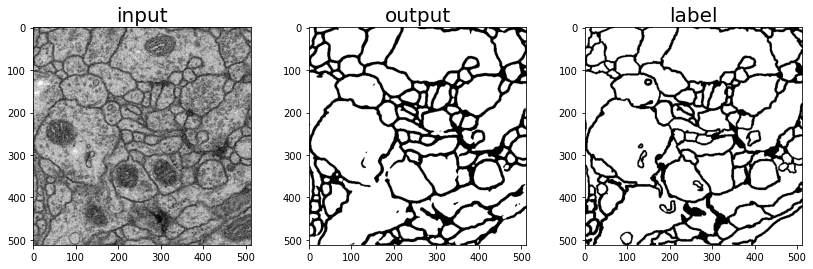

In [21]:
result_dir = './result/numpy'

lst_data = os.listdir(result_dir)

lst_label = [f for f in lst_data if f.startswith('label')] # string.startswith('argu')  : string이 argu로 시작하는지 검사
lst_input = [f for f in lst_data if f.startswith('inputs')] 
lst_output = [f for f in lst_data if f.startswith('out')]

lst_label.sort()
lst_input.sort()
lst_output.sort()

id = 2

label = np.load(os.path.join(result_dir, lst_label[id]))
inputs = np.load(os.path.join(result_dir, lst_input[id]))
output = np.load(os.path.join(result_dir, lst_output[id]))

plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['axes.titlesize'] = 10

plt.subplot(131)
plt.imshow(inputs, cmap='gray')
plt.title('input',)

plt.subplot(132)
plt.imshow(output, cmap='gray')
plt.title('output',)

plt.subplot(133)
plt.imshow(label, cmap= 'gray')
plt.title('label')
